#### **Google Colab Requirement:**
In the Google Colab notebook, this cell is included to ensure the necessary environment for the project is set up. The `pygmm` and `rasterio` packages, which are required for ground motion modeling and handling geospatial raster data, are installed.\
Google Drive is then mounted to provide access to persistent storage for file operations, and the project directory is added to the Python path to facilitate the easy import of custom modules. This configuration is essential for the seamless execution of the project.

In [19]:
!pip install pygmm
!pip install rasterio

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
base_path = '/content/drive/My Drive/Colab Notebooks/PyPSHA'
sys.path.append(base_path)

Mounted at /content/drive


# Probabilistic Seismic Hazard Analysis
This notebook conducts a **probabilistic seismic hazard analysis (PSHA)**, specifically tailored for **buildings** and **distributed lifeline systems**, such as power grids, water supply networks, and transportation systems. It considers the **spatial correlation** between infrastructural components, enabling a more realistic and detailed assessment of seismic hazards. The codes integrate data processing, scenario generation, and seismic hazard visualization.

### 1- Prerequisites
In addition to the main notebook, there are three essential classes from their respective modules, setting the stage for conducting a PSHA:

#### **InitialSetup:**
This class, imported from `initial_setup`, is responsible for initializing the PSHA process. It reads and processes the input data related to site and seismic source characteristics.
The class ensures that all necessary information is correctly loaded and formatted for subsequent analysis steps.

#### **EarquakeGenerator:**
Imported from `earthquake_generator`, this class is key to generating earthquake scenarios. It utilizes the data processed by InitialSetup to create a series of hypothetical earthquake events using Monte Carlo simulation method. This involves determining magnitudes based on a Magnitude-Frequency Distribution (MFD), assigning magnitudes to specific seismic sources, and calculating ground motion paramaters using a chosen Ground Motion Equation (GME) model. This class is crucial for simulating the diverse range of potential seismic events that could impact the study area.

#### **SeiemicHazardVisualization:**
The `seismic_hazard_visualization` class is designed to create and display seismic hazard visualizations based on the output from the `EarthquakeGenerator`. This class not only generates hazard maps to depict the spatial distribution and intensity of seismic hazards, but it also produces continuous GeoTIFF images of the intensity measures and display intensity measures for each census tract.

In [20]:
from modules.initial_setup import InitialSetup
from modules.earthquake_generator import EarthquakeGenerator
from modules.visualization import Visualization

### 2- Data Loading and Processing

In this step, essential data for the PSHA are loaded and processed.

##### **Site Data**
Site data are sourced from a CSV file, comprising:
- *IDs*
- Geographic coordinates (*latitude* and *longitude* in degrees)
- *Depths* in kilometers
- *Vs30* values in meters per second (acceptable range is between 150 to 1500 m/s)
- Soil or rock *conditions*

##### **Seismic Source Data**
Seismic source data are extracted from a JSON file, detailing:
- **Geographic coordinates**: *Latitude* and *longitude* in degrees.
- **Range of potential magnitudes**: *Minimum* and *maximum* magnitudes with an acceptable range between 3 to 8.5.
- **Recurrence rates**: Describes the frequency at which similar seismic events are expected to recur.
- **Fault mechanisms**: Categorized as *Strike-Slip (SS)*, *Normal Slip (NS)*, or *Reverse Slip (RS)*.
- **Dip**: Refers to the angle of the fault plane relative to the horizontal, measured in degrees.
- **Event type**: Classifies seismic events by their geological characteristics, typically as *interface* or *intraslab*, describing the tectonic interaction at play.







In [21]:
csv_file_path   = f'{base_path}/input_files/site_data.csv'
json_file_path  = f'{base_path}/input_files/source_data.json'

census_file_path  = f'{base_path}/input_files/shapefiles/shelby_county_census_tracts.shp'
geotiff_file_path = f'{base_path}/outputs'

setup = InitialSetup(csv_file_path, json_file_path)

### 3- Earthquake Events Generation
The `EarthquakeGenerator` class facilitates the process of simulating earthquake events through a series of defined steps:  
It starts by generating magnitudes using the **Magnitude-Frequency-Distribution** (MFD), with the *Gutenberg-Richter law*$^{1}$ currently being the only supported method.  
Each magnitude is then assigned to a specific seismic source following Bayes’ theorem. For determining **ground-motion parameters**, the class utilizes the **PYGMM package**, with the **Abrahamson, Silva and Kamai (2014)**$^{2}$ model as the sole option supported, as outlined in the [PYGMM documentation](https://readthedocs.org/projects/pygmm/downloads/pdf/dev/)$^{3}$.  
The class normalizes inter-event residuals using univariate normal distribution data and accounts for variability within a single seismic event through intra-event residuals.  
Lastly, it calculates the Intensity Measure (IM) for each scenario, focusing on Peak Ground Acceleration (PGA) in units of _g_, Spectral Acceleration (SA) in units of _g_ applicable at different periods, and Peak Ground Velocity (PGV) in units of _cm/sec_.

<hr>
$^{1}$ <small> Gutenberg, B., & Richter, C. F. (1944). Frequency of earthquakes in California. Bulletin of the Seismological society of America, 34(4), 185-188.</small>

$^{2}$ <small> David M Boore, Jonathan P Stewart, Emel Seyhan, and Gail M Atkinson. (2014). NGA-West2 equations for predicting pga, pgv, and 5% damped psa for shallow crustal earthquakes. Earthquake Spectra, 30(3):1057–1085. </small>

$^{3}$ <small>Kottke, A. (2020). pygmm Documentation. </small>

In [22]:
magnitude_frequency_distribution = 'gr_recurrence_law'
ground_motion_equation_model     = 'AbrahamsonSilvaKamai2014'

earthquake_generator = EarthquakeGenerator(setup, magnitude_frequency_distribution, ground_motion_equation_model)

scenarios_dict, scenarios_df = earthquake_generator.generate_earthquake_objects(num_scenarios=1)

### 4- Visualization
The `SeismicHazardVisualization` class creates different maps to visually represent seismic hazard.

In [23]:
visualization = Visualization(setup, earthquake_generator, scenarios_dict, num_scenarios=1, return_period=50)

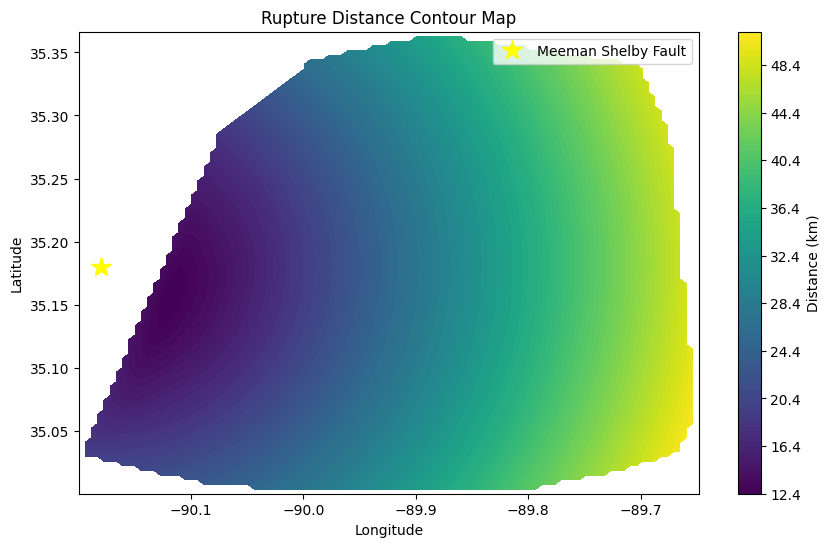

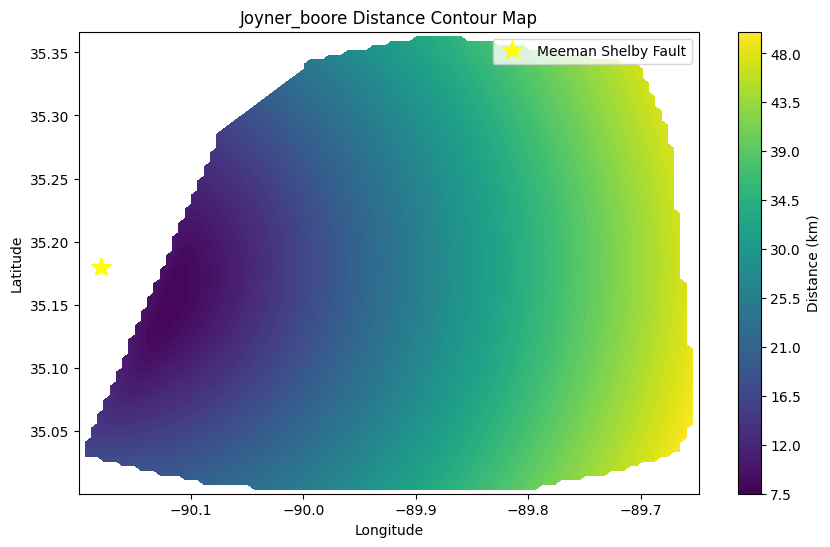

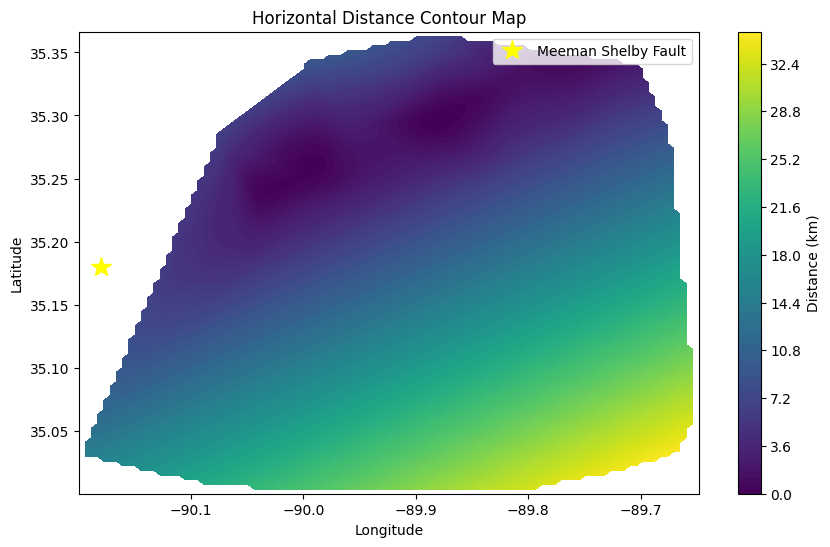

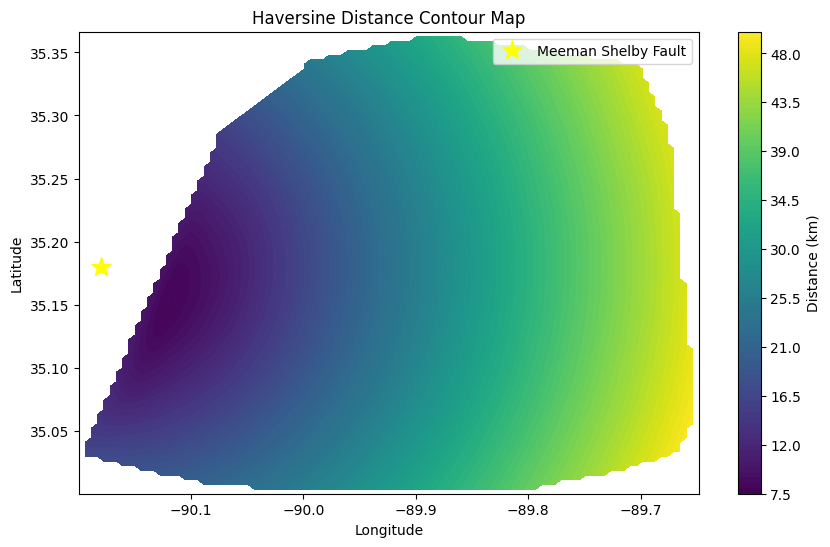

In [24]:
visualization.plot_distances_contour_map('rupture')
visualization.plot_distances_contour_map('joyner_boore')
visualization.plot_distances_contour_map('horizontal')
visualization.plot_distances_contour_map('haversine')

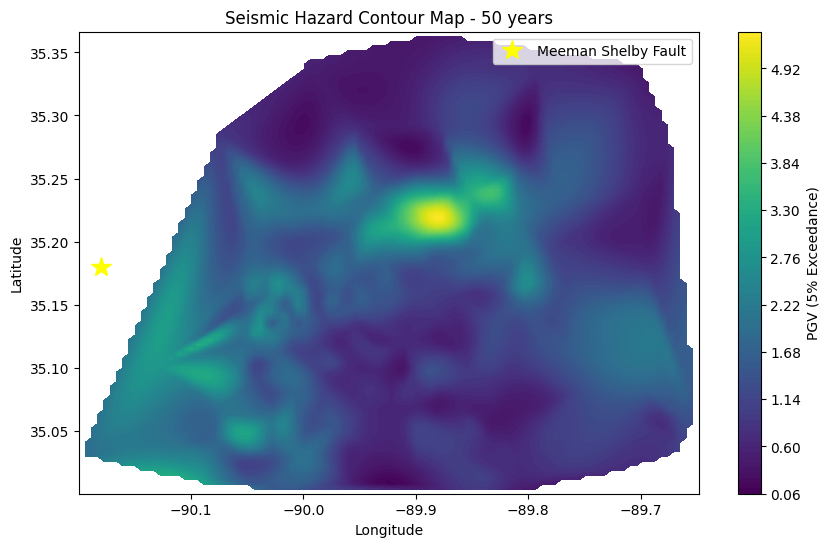

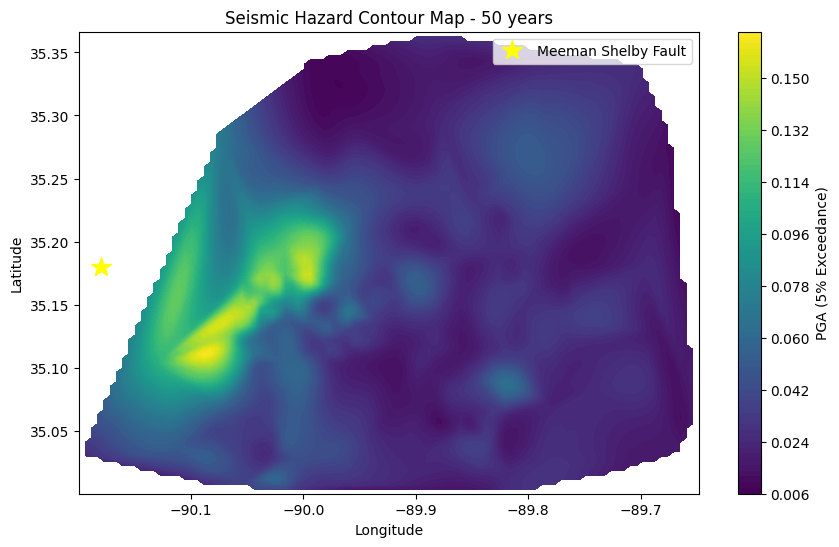

In [25]:
visualization.plot_im_contour_map(exceedance_probability=0.05, ground_motion_type='PGV')
visualization.plot_im_contour_map(exceedance_probability=0.05, ground_motion_type='PGA')

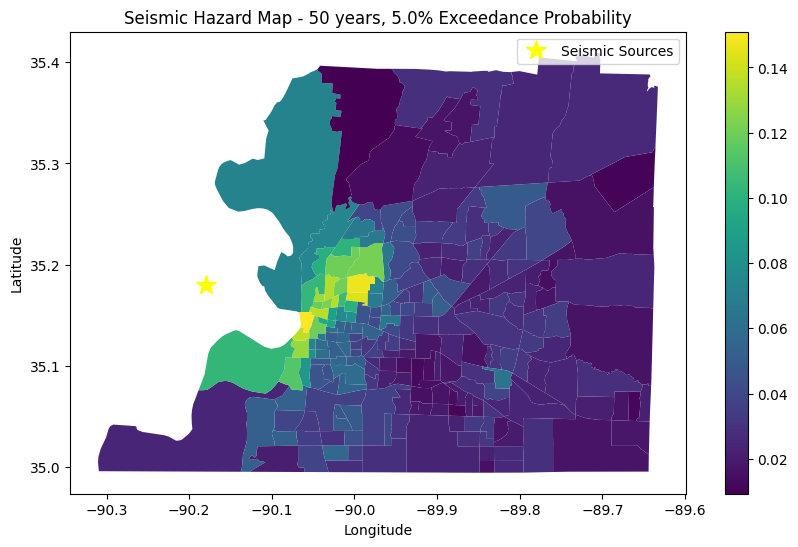

In [26]:
visualization.plot_tract_intensity_map(exceedance_probability=0.05, ground_motion_type = 'PGA', census_file_path = census_file_path)

In [27]:
visualization.generate_continuous_earthquake_geotiff(exceedance_probability=0.05, ground_motion_type = 'PGA', grid_resolution=0.001, geotiff_file_path = geotiff_file_path)
